In [2]:
import pandas as pd

df1 = pd.read_csv("takehome_user_engagement.csv")  
df1.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
df2 = pd.read_csv("takehome_users.csv", encoding="latin1")
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [10]:
import duckdb
con = duckdb.connect()
con.register("eng", df1)   
con.register("users", df2)  
sql_adopted = """
WITH e AS (
    SELECT
        user_id,
        CAST(time_stamp AS DATE) AS dt
    FROM eng
    GROUP BY user_id, CAST(time_stamp AS DATE)
),
w AS (
    SELECT
        e1.user_id,
        e1.dt AS start_dt,
        COUNT(*) AS days_in_window
    FROM e e1
    JOIN e e2
      ON e1.user_id = e2.user_id
     AND e2.dt BETWEEN e1.dt AND (e1.dt + INTERVAL 6 DAY)
    GROUP BY e1.user_id, e1.dt
),
adopted AS (
    SELECT
        user_id,
        CASE WHEN MAX(days_in_window) >= 3 THEN 1 ELSE 0 END AS adopted
    FROM w
    GROUP BY user_id
)
SELECT
    u.*,
    COALESCE(a.adopted, 0) AS adopted,
    CASE WHEN u.invited_by_user_id IS NULL THEN 0 ELSE 1 END AS was_invited
FROM users u
LEFT JOIN adopted a
  ON u.object_id = a.user_id
"""
data = con.execute(sql_adopted).df()
data.head()


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,was_invited
0,11306,2013-11-25 08:29:34,Souza Evelyn,EvelynGomesSouza@jourrapide.com,ORG_INVITE,1.393835e+09,0,0,240,10954.0,1,1
1,11527,2013-01-01 08:13:59,Watts Amber,AmberWatts@jourrapide.com,ORG_INVITE,1.399191e+09,1,1,339,10778.0,1,1
2,11294,2013-11-22 07:01:45,Iversen Jonathan,JonathanLIversen@hotmail.com,SIGNUP,1.401865e+09,0,0,361,NaN,1,0
3,11762,2013-08-05 23:00:33,Baumgartner Klaus,KlausBaumgartner@gmail.com,ORG_INVITE,1.401836e+09,0,0,405,545.0,1,1
4,11450,2012-07-06 12:59:20,Madsen Gustav,GustavJMadsen@gmail.com,ORG_INVITE,1.401800e+09,0,0,389,11236.0,1,1


In [11]:
con.register("data", data)

# 1) 总体 adopted 比例
overall = con.execute("""
SELECT AVG(adopted) AS adopted_rate, COUNT(*) AS n_users
FROM data
""").df()
overall

,adopted_rate,n_users
0,0.1335,12000


In [12]:
src = con.execute("""
SELECT
  creation_source,
  COUNT(*) AS n_users,
  AVG(adopted) AS adopted_rate
FROM data
GROUP BY 1
ORDER BY adopted_rate DESC
""").df()
src

,creation_source,n_users,adopted_rate
0,SIGNUP_GOOGLE_AUTH,1385,0.167509
1,GUEST_INVITE,2163,0.166436
2,SIGNUP,2087,0.140393
3,ORG_INVITE,4254,0.129995
4,PERSONAL_PROJECTS,2111,0.077688


In [13]:
inv = con.execute("""
SELECT
  was_invited,
  COUNT(*) AS n_users,
  AVG(adopted) AS adopted_rate
FROM data
GROUP BY 1
ORDER BY 1
""").df()
inv

,was_invited,n_users,adopted_rate
0,0,5583,0.123410
1,1,6417,0.142278


In [14]:
mail = con.execute("""
SELECT
  opted_in_to_mailing_list,
  enabled_for_marketing_drip,
  COUNT(*) AS n_users,
  AVG(adopted) AS adopted_rate
FROM data
GROUP BY 1,2
ORDER BY adopted_rate DESC
""").df()
mail

,opted_in_to_mailing_list,enabled_for_marketing_drip,n_users,adopted_rate
0,1,1,1342,0.138599
1,1,0,1652,0.138015
2,0,1,450,0.133333
3,0,0,8556,0.131837


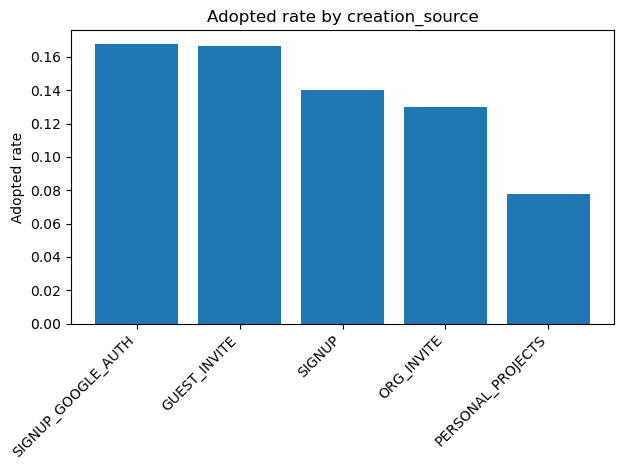

In [15]:
import matplotlib.pyplot as plt

# creation_source adoption rate bar
tmp = src.sort_values("adopted_rate", ascending=False)
plt.figure()
plt.bar(tmp["creation_source"], tmp["adopted_rate"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Adopted rate")
plt.title("Adopted rate by creation_source")
plt.tight_layout()
plt.show()

Brief Write-Up: Factors Predicting User Adoption

Goal & Definition.
Using the takehome_users and takehome_user_engagement datasets (12,000 users), I defined an “adopted user” as someone who logged into the product on three separate days within at least one 7-day period. I derived an adopted label from the daily login table by deduplicating to one login per user per day and checking whether any 7-day window contained ≥3 distinct login dates.

Overall Adoption Rate.
The overall adoption rate is 13.35% (1,602 adopted users out of 12,000).

Key Predictors (Descriptive Findings).

Acquisition / Creation Source is the strongest predictor.
Adoption varies substantially by creation_source, ranging from 7.77% to 16.75%—more than a 2× difference:

SIGNUP_GOOGLE_AUTH: 16.75% (n=1,385)

GUEST_INVITE: 16.64% (n=2,163)

SIGNUP: 14.04% (n=2,087)

ORG_INVITE: 13.00% (n=4,254)

PERSONAL_PROJECTS: 7.77% (n=2,111)

This suggests that users who join via Google authentication or are invited as guests are more likely to reach the early engagement threshold consistent with adoption, while users joining through personal projects adopt at materially lower rates.

Being invited is associated with higher adoption.
Users who were invited (was_invited = 1) have an adoption rate of 14.23% (n=6,417) vs 12.34% for non-invited users (n=5,583), an absolute lift of ~1.9 percentage points. This pattern is consistent with invitations creating immediate collaborative context or purpose, which may accelerate repeat usage in the first week.

Marketing email flags show limited separation.
Adoption rates are very similar across combinations of opted_in_to_mailing_list and enabled_for_marketing_drip (~13.18%–13.86%). Based on these flags alone, marketing email settings do not appear to be a strong standalone predictor of adoption. (This may reflect that these fields measure eligibility/opt-in rather than true exposure or engagement with emails.)

Conclusion.
From the available fields, the clearest predictive factors are how the account was created (creation_source) and, to a lesser extent, whether the user was invited. Email opt-in and drip enrollment show minimal differences in adoption rates and likely provide limited predictive value in this dataset.